# Axon Segmentation Analysis of Whole-Brain Light-Sheet Images

In [1]:
from brainlit.preprocessing import removeSmallCCs
from brainlit.BrainLine.util import json_to_points, download_subvolumes
from brainlit.BrainLine.parse_ara import *
import xml.etree.ElementTree as ET
from brainlit.BrainLine.imports import *
from brainlit.BrainLine.apply_ilastik import (
    ApplyIlastik,
    ApplyIlastik_LargeImage,
    plot_results,
)
from brainlit.BrainLine.analyze_results import (
    AxonDistribution,
    collect_regional_segmentation,
)

%gui qt5

## 1. Before Using this notebook:

### 1a. Install brainlit, and other packages that this notebook uses
### 1b. Write images to s3 using CloudReg
    - e.g. python -m cloudreg.scripts.create_precomputed_volumes --s3_input_paths /mnt/NAS/SmartSPIM_Data/2022_03_02/20220302_14_40_04_8529_destriped_DONE/Ex_561_Em_600_stitched --s3_output_paths  s3://smartspim-precomputed-volumes/2022_03_02/8529/Ch_561_v2  --voxel_size 1.83 1.83 2 --num_procs 24 --resample_iso False
### 1c. Make point annotations in neuroglancer to identify subvolumes for validation (and possible training)
    - instructions: https://neurodata.io/help/neuroglancer-pt-annotations/
        ,
    {
    "type":"pointAnnotation",
    "name": "val",
    "points": []
    }
### 1d. Update axon_data.py file

### \*Inputs\*

In [2]:
brainlit_path = Path(os.path.abspath(""))
brainlit_path = brainlit_path.parents[1]
print(f"Path to brainlit: {brainlit_path}")
data_file = brainlit_path / "experiments" / "BrainLine" / "data" / "axon_data.json"

with open(data_file) as f:
    data = json.load(f)
brain2paths = data["brain2paths"]

for id in brain2paths.keys():
    if "base" in brain2paths[id].keys() and "val_info" in brain2paths[id].keys():
        base = brain2paths[id]["base"]
        if "http" in base:
            print(f"Sample {id}: http in basepath, which may cause write errors")

        try:
            url = brain2paths[id]["val_info"]["url"]
            layer = brain2paths[id]["val_info"]["layer"]
            pts = json_to_points(url)[layer]
        except:
            print(f"Sample {id}: Error with val_info")

        if "train_info" in brain2paths[id].keys():
            try:
                url = brain2paths[id]["train_info"]["url"]
                layer = brain2paths[id]["train_info"]["layer"]
                pts = json_to_points(url)[layer]
            except:
                print(f"Sample {id}: Error with train_info")
    else:
        print(f"Sample {id}: Does not conform to desired format")

Path to brainlit: /Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit
Sample atlas: Does not conform to desired format
Sample 2: Does not conform to desired format
Sample 1: Does not conform to desired format
Sample 3: Does not conform to desired format
Sample 4: Does not conform to desired format
Sample 8613: Does not conform to desired format
Sample 8604: Does not conform to desired format
Sample 8590_v2: Does not conform to desired format
Sample 8612: Does not conform to desired format
Sample 8788: Does not conform to desired format
Sample 11537: Does not conform to desired format
Sample pytest: Does not conform to desired format


## 2. Download benchmark data

### \*Inputs\*

In [3]:
antibody_layer = "Ch_647"
background_layer = "Ch_561"
endogenous_layer = "Ch_488"

brain = "MS11"  # brain ID
axon_data_dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/"  # path to directory where training/validation data should be stored
dataset_to_save = "val"  # train or val

In [ ]:
cvol_base = brain2paths[brain]["base"]
layer_names = [antibody_layer, background_layer, endogenous_layer]

for layer in [antibody_layer, background_layer, endogenous_layer]:
    try:
        CloudVolume(cvol_base + layer)
    except:
        print(f"Sample {id}: Layer {layer} not found in {cvol_base}")

if brain not in brain2paths.keys():
    raise ValueError(f"brain {brain} not an entry in brain2paths in axon_data.py file")

if f"{dataset_to_save}_info" not in brain2paths[
    brain
].keys() or dataset_to_save not in ["train", "val"]:
    raise ValueError(f"{dataset_to_save}_info not in brain2paths[{brain}].keys()")

### Download data

In [ ]:
download_subvolumes(
    axon_data_dir,
    brain_id=brain,
    layer_names=layer_names,
    dataset_to_save=dataset_to_save,
    object_type="axon",
)

## 3. View downloaded data (optional)

### \*Inputs\*

In [ ]:
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain8649/val_775_4829_2459.h5"  # path to file for viewing
scale = [1.8, 1.8, 2]  # voxel size in microns

In [ ]:
with h5py.File(fname, "r") as f:
    pred = f.get("image_2channel")
    image_bg = pred[0, :, :, :]
    image_fg = pred[1, :, :, :]
    image_endo = pred[2, :, :, :]

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_fg, scale=scale)
viewer.add_image(image_bg, scale=scale)
viewer.add_image(image_endo, scale=scale)
viewer.scale_bar.visible = True
viewer.scale_bar.unit = "um"

## 4. Apply Ilastik to validation data

You will need to do two things:
- add annotations to the downloaded data (for me, partial labels on 3 of the z-slices using ilastik)
- apply axon segmentation model to the downloaded data. Results should be located in the same directory at the subvolumes, with the addition of "_Probabilities" appended to the file names: you can do this programmatically (below), or you can use the ilastik GUI (which is sometimes faster)

Note: make sure foreground/background labels are matched between the model and your annotations (for me, blue/1 =axon yellow/0=bg)

In [4]:
project_path = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/axon_segmentation.ilp"  # path to ilastik model to be used
ilastik_path = (
    "/Applications/ilastik-1.4.0b21-OSX.app/Contents/ilastik-release/run_ilastik.sh"
)
brains = [brain]
brains = ["8650", "8613", "8589", "8788", "8786", "8790", "MS32", "MS29", "MS11", "MS15", "11537"]

In [ ]:
applyilastik = ApplyIlastik(
    ilastik_path=ilastik_path,
    project_path=project_path,
    brains_path=axon_data_dir,
    brains=brains,
)
applyilastik.process_subvols()

## 5. Check results

Processing Brains: 100%|██████████| 11/11 [00:47<00:00,  4.32s/it]


If this performance is not adequate, improve model and try again
Brain 11537 Validation: 613+ 10762-


(<Figure size 576x576 with 1 Axes>, 0.9080459770114943, 0.88)

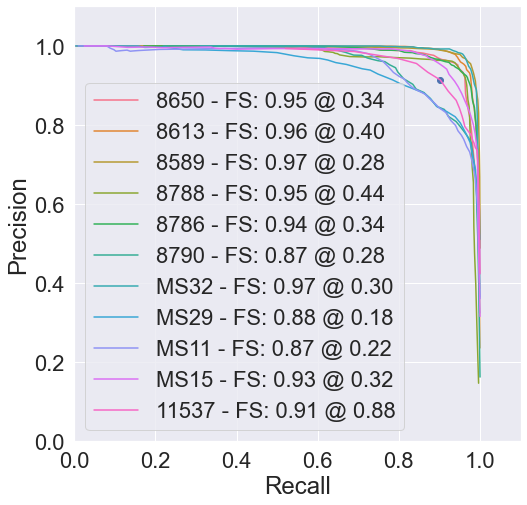

In [5]:
plot_results(
    data_dir=axon_data_dir, brain_ids=brains, object_type="axon", positive_channel=1
)

### If results above are not adequate improve the model and try again

In my case, I identify more subvolumes from the sample at hand using the same process as for validation data, and add it as training data to the model and retrain.


### Examine best threshold

In [ ]:
files = os.listdir(base_dir)
files = [base_dir + f for f in files if "val" in f]
files = [f for f in files if "_Probabilities.h5" in f]
print(f"{len(files)} total validation subvolumes")


for i, fname_prob in enumerate(files):
    fname_im = fname_prob[:-17] + ".h5"
    f = h5py.File(fname_im, "r")
    im = f.get("image_2channel")
    im_bg = im[0, :, :, :]
    im_fg = im[1, :, :, :]
    im_endo = im[2, :, :, :]

    fname_lab = fname_prob[:-17] + "-image_2channel_Labels.h5"
    f = h5py.File(fname_lab, "r")
    gt = f.get("exported_data")
    gt = gt[0, :, :, :]
    pos_labels = gt == 2
    neg_labels = gt == 1

    f = h5py.File(fname_prob, "r")
    seg = f.get("exported_data")
    seg = seg[1, :, :, :]
    mask = seg > best_threshold

    true_pos = np.sum(np.logical_and(mask, pos_labels))
    false_pos = np.sum(np.logical_and(mask, gt == 1))
    true_labels = np.sum(pos_labels)
    true_labels_neg = np.sum(neg_labels)

    if true_labels == 0:
        recall = 1
    else:
        recall = true_pos / true_labels

    if true_pos + false_pos == 0:
        precision = 1
    else:
        precision = true_pos / (true_pos + false_pos)

    if precision < 0.8 or recall < 0.8:
        print(f"{i}) {fname_prob}: prec{precision} recall: {recall}")
        viewer = napari.Viewer(ndisplay=3)
        viewer.add_image(im_fg, name=f"fg {i}")
        viewer.add_image(im_bg, name="bg")
        viewer.add_image(im_endo, name="endo")
        viewer.add_labels(mask, name="mask")
        viewer.add_labels(pos_labels + 2 * neg_labels, name="pos labels")

### Paper figure for all validation

In [ ]:
brains = ["8650", "8613", "8589", "8788", "8786", "8790", "MS32", "MS29", "MS11", "MS15", "11537"]

brain_ids = []
precisions = []
recalls = []

best_precisions = []
best_recalls = []
best_fscores = {}

for brain_id in brains:
    base_dir = (
        "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain"
        + brain_id
        + "/"
    )

    spacing = 0.02
    thresholds = np.arange(spacing, 1.0, spacing)
    best_fscore = 0

    files = os.listdir(base_dir)
    files = [base_dir + f for f in files if "val" in f]
    files = [f for f in files if "_Probabilities.h5" in f]
    fiiles = [f for f in files if "val" in f]

    print(f"{len(files)} total validation subvolumes for brain {brain_id}")

    for threshold in thresholds:
        true_pos_total = 0
        false_pos_total = 0
        true_labels_total = 0
        true_labels_total_neg = 0
        for fname_prob in files:
            fname_im = fname_prob[:-17] + ".h5"
            f = h5py.File(fname_im, "r")
            im = f.get("image_2channel")
            im_bg = im[0, :, :, :]
            im_fg = im[1, :, :, :]

            fname_lab = fname_prob[:-17] + "-image_2channel_Labels.h5"
            f = h5py.File(fname_lab, "r")
            gt = f.get("exported_data")
            gt = gt[0, :, :, :]
            pos_labels = gt == 2
            neg_labels = gt == 1

            f = h5py.File(fname_prob, "r")
            seg = f.get("exported_data")
            seg = seg[1, :, :, :]
            mask = seg > threshold

            true_pos = np.sum(np.logical_and(mask, pos_labels))
            true_pos_total += true_pos
            false_pos = np.sum(np.logical_and(mask, gt == 1))
            false_pos_total += false_pos
            true_labels = np.sum(pos_labels)
            true_labels_total += true_labels
            true_labels_neg = np.sum(neg_labels)
            true_labels_total_neg += true_labels_neg

        precision_total = true_pos_total / (true_pos_total + false_pos_total)
        recall_total = true_pos_total / true_labels_total

        precisions.append(precision_total)
        recalls.append(recall_total)
        brain_ids.append(brain_id)

        fscore = 2 / (1 / precision_total + 1 / recall_total)

        if fscore > best_fscore:
            best_fscore = fscore
            best_prec = precision_total
            best_recall = recall_total
            best_threshold = threshold
    best_precisions.append(best_prec)
    best_recalls.append(best_recall)
    best_fscores[brain_id] = best_fscore
for i, brain_id in enumerate(brain_ids):
    brain_ids[i] = brain_id + f" - Max F-score: {best_fscores[brain_id]:.2f}"

data = {"Sample": brain_ids, "Recall": recalls, "Precision": precisions}
df = pd.DataFrame(data=data)


sns.set(rc={"figure.figsize": (10, 7)})
sns.set(font_scale=2)
sns.lineplot(data=df, x="Recall", y="Precision", hue="Sample")
sns.scatterplot(x=best_recalls, y=best_precisions)

## 6. Make annotation layers

### Axon segmentation

In [ ]:
if "base" in brain2paths[brain].keys():
    dir = brain2paths[brain]["base"] + "axon_mask"
else:
    dir = brain2paths[brain]["mask"]

try:
    CloudVolume(dir)
except:
    info = CloudVolume.create_new_info(
        num_channels=1,
        layer_type="segmentation",
        data_type="uint64",  # Channel images might be 'uint8'
        encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
        resolution=vol_bg.resolution,  # Voxel scaling, units are in nanometers
        voxel_offset=vol_bg.voxel_offset,  # x,y,z offset in voxels from the origin
        # mesh            = 'mesh',
        # Pick a convenient size for your underlying chunk representation
        # Powers of two are recommended, doesn't need to cover image exactly
        chunk_size=[128, 128, 2],  # units are voxels
        volume_size=vol_bg.volume_size,  # e.g. a cubic millimeter dataset
    )
    vol_mask = CloudVolume(dir, info=info)
    vol_mask.commit_info()

### Transformed layers

In [ ]:
atlas_vol = CloudVolume(
    "precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017"
)
for layer in [
    antibody_layer,
    background_layer,
    "axon_mask",
]:  # axon_mask is transformed into an image because nearest interpolation doesnt work well after downsampling
    layer_path = brain2paths[brain]["base"] + layer + "_transformed"
    info = CloudVolume.create_new_info(
        num_channels=1,
        layer_type="image",
        data_type="uint16",  # Channel images might be 'uint8'
        encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
        resolution=atlas_vol.resolution,  # Voxel scaling, units are in nanometers
        voxel_offset=atlas_vol.voxel_offset,
        chunk_size=[32, 32, 32],  # units are voxels
        volume_size=atlas_vol.volume_size,  # e.g. a cubic millimeter dataset
    )
    vol_mask = CloudVolume(layer_path, info=info)
    vol_mask.commit_info()

## 7. Apply ilastik to whole image:

### \* Inputs \*

You can use the notebook code below or the script using `axon_segment_image.py`

In [ ]:
brain = "test"
antibody_layer = "antibody"
background_layer = "background"
endogenous_layer = "endogenous"

threshold = 0.12  # threshold to use for ilastik
data_dir = (
    str(Path.cwd().parents[0]) + "/brain_temp/"
)  # data_dir = "/data/tathey1/matt_wright/brain_temp/"  # directory to store temporary subvolumes for segmentation

# Ilastik will run in "headless mode", and the following paths are needed to do so:
ilastik_path = "/Applications/ilastik-1.4.0b21-OSX.app/Contents/ilastik-release/run_ilastik.sh"  # "/data/tathey1/matt_wright/ilastik/ilastik-1.4.0rc5-Linux/run_ilastik.sh"  # path to ilastik executable
ilastik_project = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/axon_segmentation.ilp"  # "/data/tathey1/matt_wright/ilastik/model1/axon_segmentation.ilp"  # path to ilastik project


max_coords = [
    3072,
    4352,
    1792,
]  # max coords or -1 if you want to process everything along that dimension
ncpu = 1  # 16  # number of cores to use for detection
chunk_size = [256, 256, 256]  # [256, 256, 300]

In [ ]:
layer_names = [antibody_layer, background_layer, endogenous_layer]
alli = ApplyIlastik_LargeImage(
    ilastik_path=ilastik_path,
    ilastik_project=ilastik_project,
    ncpu=ncpu,
    object_type="axon",
)
alli.apply_ilastik_parallel(
    brain_id=brain,
    layer_names=layer_names,
    threshold=threshold,
    data_dir=data_dir,
    chunk_size=chunk_size,
    max_coords=max_coords,
)
alli.collect_axon_results(brain_id=brain, ng_layer_name="127.0.0.1:9010")

## 8. Register volume and transform data to atlas space using CloudReg

### 8a. You need to find an initial affine alignment using cloudreg.scripts.registration.get_affine_matrix. For example: 



A link to the ARA parcellation is:

`precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017`

And some python commands to help with affine alignment is:

```
from cloudreg.scripts.registration import get_affine_matrix
get_affine_matrix([1,1,1], [15,0,0], "PIR", "RAI", 1.15, "precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017")
```

### 8b. Run registration using cloudreg.scripts.registration. For example:

```
python -m cloudreg.scripts.registration -input_s3_path precomputed://s3://smartspim-precomputed-volumes/2023_04_10/MS11/Ch_561 --output_s3_path precomputed://s3://smartspim-precomputed-volumes/2023_04_10/MS11/atlas_to_target --atlas_s3_path https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_50um/average_50um --parcellation_s3_path https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017 --atlas_orientation PIR -orientation RPI --rotation -5 0 0 --translation 0 0 0 --fixed_scale 1.05 -log_s3_path precomputed://s3://smartspim-precomputed-volumes/2023_04_10/MS11/atlas_to_target --missing_data_correction True --grid_correction False --bias_correction True --regularization 5000.0 --iterations 3000 --registration_resolution 100
```

### 8c. Transform segmentation to atlas space using CloudReg

```
python -m cloudreg.scripts.transform_data --target_layer_source precomputed://s3://smartspim-precomputed-volumes/2022_10_26/11537/axon_mask --transformed_layer_source precomputed://s3://smartspim-precomputed-volumes/2022_10_26/11537/axon_mask_transformed --affine_path /mnt/NAS/Neuroglancer\ Data/2023_04_07/MS29_Ch_561_registration/downloop_1_A.mat  --velocity_path /mnt/NAS/Neuroglancer\ Data/2023_04_07/MS29_Ch_561_registration/downloop_1_v.mat
```

python -m cloudreg.scripts.transform_data --target_layer_source precomputed://s3://smartspim-precomputed-volumes/2022_10_26/11537/axon_mask --transformed_layer_source precomputed://s3://smartspim-precomputed-volumes/2022_10_26/11537/axon_mask_transformed --affine_path /cis/home/tathey/11537_Ch_561_registration/downloop_1_A.mat  --velocity_path /cis/home/tathey/11537_Ch_561_registration/downloop_1_v.mat

This will write a layer to s3 with the transformed axon mask. The s3 path to this layer should be added to `axon_data.py` under the `axon_mask_transformed` key. Then the code below, or `axon_brainrender.py`, can be used to visualize the data.

## 9. Combine registration and segmentation results

In [ ]:
collect_regional_segmentation(
    brain_id=brain,
    outdir=axon_data_dir,
    max_coords=[
        6029,
        -1,
        -1,
    ],
)

## 10. View coronal heat maps

### \*Inputs\*

In [4]:
brain_ids = [
    # "3",
    # "4",
    "8613",
    # "8604",
    "8650",
    "8589",
    # "8590",
    # "8649",
    "8788",
    "8786",
    "11537",
    "8790",
    "MS32",
    "MS29",
    "MS11",
    "MS15",
]  # list of sample IDs to be shown

brain_ids = [
    # "3",
    # "4",
    "8613",
    # "8604",
    "8650",
    "8589",
    # "8590",
    # "8649",
    "8788",
    "8786",
    # "11537",
    "8790",
    "MS32",
    "MS29",
    "MS11",
    "MS15",
]  # list of sample IDs to be shown

colors = {
    "tph2 gad2": "red",
    "tph2 vglut3": "blue",
    "gad2 vgat": "green",
}  # colors for different genotypes
fold_on = False
ontology_file = brainlit_path / "BrainLine" "data" / "ara_structure_ontology.json"

axon_data_dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/wholebrain_results/"

ad = AxonDistribution(
    brain_ids=brain_ids, regional_distribution_dir=axon_data_dir, data_file=data_file, ontology_file=ontology_file
)

In [ ]:
z_size = 1320
for z in tqdm(np.arange(50, z_size, 50)):
    ad.napari_coronal_section(z=z, subtype_colors=colors, fold_on=fold_on)

In [5]:
dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/matt-coronals/"
z_size = 1320

for z in tqdm(np.arange(50, z_size, 50)):
    fname = dir + f"{brain}_{z}_axon.tif"
    v = ad.napari_coronal_section(
        z=z, subtype_colors=colors, fold_on=False
    )
    im = v.screenshot(canvas_only=False)
    io.imsave(fname, im)

Processing labels: 100%|██████████| 8/8 [00:00<00:00, 61.03it/s]


8613


Downloading: 100%|██████████| 900/900 [00:05<00:00, 171.67it/s]


8650


Downloading: 100%|██████████| 900/900 [00:04<00:00, 186.19it/s]


8589


Downloading: 100%|██████████| 900/900 [00:05<00:00, 173.85it/s]


8788


Downloading: 100%|██████████| 900/900 [00:05<00:00, 174.85it/s]


8786


Downloading: 100%|██████████| 900/900 [00:11<00:00, 81.48it/s]


8790


Downloading: 100%|██████████| 900/900 [00:06<00:00, 128.72it/s]


MS32


Downloading: 100%|██████████| 900/900 [00:04<00:00, 187.24it/s]


MS29


Downloading: 100%|██████████| 900/900 [00:05<00:00, 169.73it/s]


MS11


Downloading: 100%|██████████| 900/900 [00:05<00:00, 153.19it/s]


MS15


Processing labels: 100%|██████████| 13/13 [00:00<00:00, 61.70it/s]


8613


Downloading: 100%|██████████| 1800/1800 [00:09<00:00, 184.31it/s]


8650


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 167.08it/s]


8589


Downloading: 100%|██████████| 1800/1800 [00:15<00:00, 119.39it/s]


8788


Downloading: 100%|██████████| 1800/1800 [00:12<00:00, 141.20it/s]


8786


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 179.04it/s]


8790


Downloading: 100%|██████████| 1800/1800 [00:12<00:00, 148.83it/s]


MS32


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 177.09it/s]


MS29


Downloading: 100%|██████████| 1800/1800 [00:17<00:00, 101.22it/s]


MS11


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 176.25it/s]


MS15


Processing labels: 100%|██████████| 33/33 [00:00<00:00, 65.48it/s]


8613


Downloading: 100%|██████████| 900/900 [00:05<00:00, 174.53it/s]


8650


Downloading: 100%|██████████| 900/900 [00:04<00:00, 189.72it/s]


8589


Downloading: 100%|██████████| 900/900 [00:09<00:00, 92.24it/s] 


8788


Downloading: 100%|██████████| 900/900 [00:07<00:00, 120.29it/s]


8786


Downloading: 100%|██████████| 900/900 [00:05<00:00, 178.14it/s]


8790


Downloading: 100%|██████████| 900/900 [00:04<00:00, 194.47it/s]


MS32


Downloading: 100%|██████████| 900/900 [00:05<00:00, 169.96it/s]


MS29


Downloading: 100%|██████████| 900/900 [00:04<00:00, 191.72it/s]


MS11


Downloading: 100%|██████████| 900/900 [00:05<00:00, 172.03it/s]


MS15


Processing labels: 100%|██████████| 15/15 [00:00<00:00, 60.92it/s]


8613


Downloading: 100%|██████████| 1800/1800 [00:09<00:00, 184.85it/s]


8650


Downloading: 100%|██████████| 1800/1800 [00:09<00:00, 188.07it/s]


8589


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 165.90it/s]


8788


Downloading: 100%|██████████| 1800/1800 [00:09<00:00, 183.10it/s]


8786


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 170.15it/s]


8790


Downloading: 100%|██████████| 1800/1800 [00:18<00:00, 99.83it/s]


MS32


Downloading: 100%|██████████| 1800/1800 [00:09<00:00, 186.67it/s]


MS29


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 165.38it/s]


MS11


Downloading: 100%|██████████| 1800/1800 [00:09<00:00, 180.40it/s]


MS15


Processing labels: 100%|██████████| 24/24 [00:00<00:00, 63.86it/s]


8613


Downloading: 100%|██████████| 1800/1800 [00:17<00:00, 102.78it/s]


8650


Downloading: 100%|██████████| 1800/1800 [00:09<00:00, 182.61it/s]


8589


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 159.74it/s]


8788


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 176.06it/s]


8786


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 174.04it/s]


8790


Downloading: 100%|██████████| 1800/1800 [00:09<00:00, 184.92it/s]


MS32


Downloading: 100%|██████████| 1800/1800 [00:09<00:00, 185.09it/s]


MS29


Downloading: 100%|██████████| 1800/1800 [00:09<00:00, 188.36it/s]


MS11


Downloading: 100%|██████████| 1800/1800 [00:09<00:00, 184.94it/s]


MS15


Processing labels: 100%|██████████| 9/9 [00:00<00:00, 56.98it/s]


8613


Downloading: 100%|██████████| 900/900 [00:06<00:00, 147.74it/s]


8650


Downloading: 100%|██████████| 900/900 [00:04<00:00, 185.84it/s]


8589


Downloading: 100%|██████████| 900/900 [00:05<00:00, 163.64it/s]


8788


Downloading: 100%|██████████| 900/900 [00:04<00:00, 185.11it/s]


8786


Downloading: 100%|██████████| 900/900 [00:05<00:00, 164.59it/s]


8790


Downloading: 100%|██████████| 900/900 [00:07<00:00, 116.29it/s]


MS32


Downloading: 100%|██████████| 900/900 [00:05<00:00, 179.13it/s]


MS29


Downloading: 100%|██████████| 900/900 [00:04<00:00, 181.04it/s]


MS11


Downloading: 100%|██████████| 900/900 [00:06<00:00, 134.96it/s]


MS15


Processing labels: 100%|██████████| 29/29 [00:00<00:00, 80.53it/s]


8613


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 157.69it/s]


8650


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 173.20it/s]


8589


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 170.78it/s]


8788


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 173.06it/s]


8786


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 165.99it/s]


8790


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 175.40it/s]


MS32


Downloading: 100%|██████████| 1800/1800 [00:09<00:00, 189.18it/s]


MS29


Downloading: 100%|██████████| 1800/1800 [00:13<00:00, 136.09it/s]


MS11


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 174.09it/s]


MS15


Processing labels: 100%|██████████| 33/33 [00:00<00:00, 59.79it/s]


8613


Downloading: 100%|██████████| 900/900 [00:05<00:00, 157.75it/s]


8650


Downloading: 100%|██████████| 900/900 [00:05<00:00, 167.87it/s]


8589


Downloading: 100%|██████████| 900/900 [00:05<00:00, 158.72it/s]


8788


Downloading: 100%|██████████| 900/900 [00:05<00:00, 174.66it/s]


8786


Downloading: 100%|██████████| 900/900 [00:05<00:00, 161.88it/s]


8790


Downloading: 100%|██████████| 900/900 [00:04<00:00, 189.85it/s]


MS32


Downloading: 100%|██████████| 900/900 [00:05<00:00, 177.21it/s]


MS29


Downloading: 100%|██████████| 900/900 [00:05<00:00, 175.52it/s]


MS11


Downloading: 100%|██████████| 900/900 [00:08<00:00, 104.28it/s]


MS15


Processing labels: 100%|██████████| 54/54 [00:00<00:00, 75.82it/s]


8613


Downloading: 100%|██████████| 1800/1800 [00:12<00:00, 147.19it/s]


8650


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 177.27it/s]


8589


Downloading: 100%|██████████| 1800/1800 [00:12<00:00, 149.10it/s]


8788


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 175.94it/s]


8786


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 172.15it/s]


8790


Downloading: 100%|██████████| 1800/1800 [00:09<00:00, 186.74it/s]


MS32


Downloading: 100%|██████████| 1800/1800 [00:12<00:00, 148.05it/s]


MS29


Downloading: 100%|██████████| 1800/1800 [00:12<00:00, 148.51it/s]


MS11


Downloading: 100%|██████████| 1800/1800 [00:14<00:00, 127.49it/s]


MS15


Processing labels: 100%|██████████| 61/61 [00:00<00:00, 72.71it/s]


8613


Downloading: 100%|██████████| 900/900 [00:10<00:00, 85.16it/s]


8650


Downloading: 100%|██████████| 900/900 [00:09<00:00, 98.55it/s]


8589


Downloading: 100%|██████████| 900/900 [00:10<00:00, 88.59it/s]


8788


Downloading: 100%|██████████| 900/900 [00:05<00:00, 161.76it/s]


8786


Downloading: 100%|██████████| 900/900 [00:06<00:00, 139.16it/s]


8790


Downloading: 100%|██████████| 900/900 [00:06<00:00, 143.70it/s]


MS32


Downloading: 100%|██████████| 900/900 [00:05<00:00, 169.59it/s]


MS29


Downloading: 100%|██████████| 900/900 [00:05<00:00, 160.88it/s]


MS11


Downloading: 100%|██████████| 900/900 [00:08<00:00, 110.19it/s]


MS15


Processing labels: 100%|██████████| 91/91 [00:01<00:00, 65.71it/s]


8613


Downloading: 100%|██████████| 1800/1800 [00:13<00:00, 135.09it/s]


8650


Downloading: 100%|██████████| 1800/1800 [00:18<00:00, 99.26it/s]


8589


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 154.55it/s]


8788


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 154.07it/s]


8786


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 159.45it/s]


8790


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 155.84it/s]


MS32


Downloading: 100%|██████████| 1800/1800 [00:17<00:00, 102.34it/s]


MS29


Downloading: 100%|██████████| 1800/1800 [00:15<00:00, 117.60it/s]


MS11


Downloading: 100%|██████████| 1800/1800 [00:13<00:00, 133.67it/s]


MS15


Processing labels: 100%|██████████| 89/89 [00:01<00:00, 78.34it/s]


8613


Downloading: 100%|██████████| 1800/1800 [00:12<00:00, 148.19it/s]


8650


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 171.57it/s]


8589


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 165.31it/s]


8788


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 161.34it/s]


8786


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 157.16it/s]


8790


Downloading: 100%|██████████| 1800/1800 [00:09<00:00, 185.09it/s]


MS32


Downloading: 100%|██████████| 1800/1800 [00:09<00:00, 182.68it/s]


MS29


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 179.16it/s]


MS11


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 169.52it/s]


MS15


Processing labels: 100%|██████████| 108/108 [00:01<00:00, 84.04it/s]


8613


Downloading: 100%|██████████| 900/900 [00:09<00:00, 91.68it/s]


8650


Downloading: 100%|██████████| 900/900 [00:09<00:00, 93.87it/s] 


8589


Downloading: 100%|██████████| 900/900 [00:09<00:00, 92.22it/s]


8788


Downloading: 100%|██████████| 900/900 [00:05<00:00, 157.37it/s]


8786


Downloading: 100%|██████████| 900/900 [00:06<00:00, 148.03it/s]


8790


Downloading: 100%|██████████| 900/900 [00:05<00:00, 161.77it/s]


MS32


Downloading: 100%|██████████| 900/900 [00:05<00:00, 160.30it/s]


MS29


Downloading: 100%|██████████| 900/900 [00:06<00:00, 133.39it/s]


MS11


Downloading: 100%|██████████| 900/900 [00:06<00:00, 141.63it/s]


MS15


Processing labels: 100%|██████████| 194/194 [00:02<00:00, 85.23it/s]


8613


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 165.54it/s]


8650


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 165.35it/s]


8589


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 165.40it/s]


8788


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 164.19it/s]


8786


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 167.56it/s]


8790


Downloading: 100%|██████████| 1800/1800 [00:09<00:00, 180.22it/s]


MS32


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 164.11it/s]


MS29


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 161.28it/s]


MS11


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 166.22it/s]


MS15


Processing labels: 100%|██████████| 135/135 [00:01<00:00, 85.84it/s]


8613


Downloading: 100%|██████████| 900/900 [00:05<00:00, 152.77it/s]


8650


Downloading: 100%|██████████| 900/900 [00:05<00:00, 162.01it/s]


8589


Downloading: 100%|██████████| 900/900 [00:06<00:00, 149.51it/s]


8788


Downloading: 100%|██████████| 900/900 [00:05<00:00, 168.40it/s]


8786


Downloading: 100%|██████████| 900/900 [00:05<00:00, 162.82it/s]


8790


Downloading: 100%|██████████| 900/900 [00:07<00:00, 113.94it/s]


MS32


Downloading: 100%|██████████| 900/900 [00:06<00:00, 138.62it/s]


MS29


Downloading: 100%|██████████| 900/900 [00:06<00:00, 138.07it/s]


MS11


Downloading: 100%|██████████| 900/900 [00:05<00:00, 157.88it/s]


MS15


Processing labels: 100%|██████████| 141/141 [00:01<00:00, 84.92it/s]


8613


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 168.76it/s]


8650


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 168.87it/s]


8589


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 165.11it/s]


8788


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 164.70it/s]


8786


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 168.03it/s]


8790


Downloading: 100%|██████████| 1800/1800 [00:17<00:00, 100.27it/s]


MS32


Downloading: 100%|██████████| 1800/1800 [00:17<00:00, 103.53it/s]


MS29


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 166.41it/s]


MS11


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 152.70it/s]


MS15


Processing labels: 100%|██████████| 124/124 [00:01<00:00, 82.68it/s]


8613


Downloading: 100%|██████████| 900/900 [00:05<00:00, 152.66it/s]


8650


Downloading: 100%|██████████| 900/900 [00:05<00:00, 166.27it/s]


8589


Downloading: 100%|██████████| 900/900 [00:05<00:00, 155.29it/s]


8788


Downloading: 100%|██████████| 900/900 [00:05<00:00, 172.44it/s]


8786


Downloading: 100%|██████████| 900/900 [00:09<00:00, 90.72it/s] 


8790


Downloading: 100%|██████████| 900/900 [00:08<00:00, 104.67it/s]


MS32


Downloading: 100%|██████████| 900/900 [00:08<00:00, 100.10it/s]


MS29


Downloading: 100%|██████████| 900/900 [00:07<00:00, 125.87it/s]


MS11


Downloading: 100%|██████████| 900/900 [00:05<00:00, 157.96it/s]


MS15


Processing labels: 100%|██████████| 105/105 [00:01<00:00, 83.10it/s]


8613


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 166.92it/s]


8650


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 168.67it/s]


8589


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 167.77it/s]


8788


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 169.08it/s]


8786


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 163.00it/s]


8790


Downloading: 100%|██████████| 1800/1800 [00:09<00:00, 182.60it/s]


MS32


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 174.19it/s]


MS29


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 166.10it/s]


MS11


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 165.62it/s]


MS15


Processing labels: 100%|██████████| 92/92 [00:01<00:00, 88.02it/s]


8613


Downloading: 100%|██████████| 900/900 [00:05<00:00, 150.28it/s]


8650


Downloading: 100%|██████████| 900/900 [00:05<00:00, 157.23it/s]


8589


Downloading: 100%|██████████| 900/900 [00:06<00:00, 134.73it/s]


8788


Downloading: 100%|██████████| 900/900 [00:05<00:00, 159.00it/s]


8786


Downloading: 100%|██████████| 900/900 [00:05<00:00, 159.98it/s]


8790


Downloading: 100%|██████████| 900/900 [00:05<00:00, 166.85it/s]


MS32


Downloading: 100%|██████████| 900/900 [00:05<00:00, 161.85it/s]


MS29


Downloading: 100%|██████████| 900/900 [00:05<00:00, 168.73it/s]


MS11


Downloading: 100%|██████████| 900/900 [00:05<00:00, 157.61it/s]


MS15


Processing labels: 100%|██████████| 92/92 [00:01<00:00, 85.76it/s]


8613


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 150.21it/s]


8650


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 165.50it/s]


8589


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 161.79it/s]


8788


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 156.51it/s]


8786


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 162.00it/s]


8790


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 171.91it/s]


MS32


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 173.81it/s]


MS29


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 171.27it/s]


MS11


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 159.03it/s]


MS15


Processing labels: 100%|██████████| 91/91 [00:01<00:00, 83.33it/s]


8613


Downloading: 100%|██████████| 1800/1800 [00:12<00:00, 142.26it/s]


8650


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 169.05it/s]


8589


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 155.02it/s]


8788


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 164.85it/s]


8786


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 170.66it/s]


8790


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 171.66it/s]


MS32


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 176.31it/s]


MS29


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 166.83it/s]


MS11


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 169.67it/s]


MS15


Processing labels: 100%|██████████| 72/72 [00:00<00:00, 86.70it/s]


8613


Downloading: 100%|██████████| 900/900 [00:05<00:00, 156.10it/s]


8650


Downloading: 100%|██████████| 900/900 [00:05<00:00, 163.94it/s]


8589


Downloading: 100%|██████████| 900/900 [00:05<00:00, 160.15it/s]


8788


Downloading: 100%|██████████| 900/900 [00:06<00:00, 148.89it/s]


8786


Downloading: 100%|██████████| 900/900 [00:05<00:00, 169.20it/s]


8790


Downloading: 100%|██████████| 900/900 [00:05<00:00, 177.89it/s]


MS32


Downloading: 100%|██████████| 900/900 [00:05<00:00, 167.78it/s]


MS29


Downloading: 100%|██████████| 900/900 [00:05<00:00, 171.40it/s]


MS11


Downloading: 100%|██████████| 900/900 [00:05<00:00, 156.49it/s]


MS15


Processing labels: 100%|██████████| 71/71 [00:00<00:00, 83.47it/s]


8613


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 162.47it/s]


8650


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 156.67it/s]


8589


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 163.69it/s]


8788


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 163.62it/s]


8786


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 169.73it/s]


8790


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 166.43it/s]


MS32


Downloading: 100%|██████████| 1800/1800 [00:09<00:00, 182.38it/s]


MS29


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 173.24it/s]


MS11


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 168.19it/s]


MS15


Processing labels: 100%|██████████| 50/50 [00:00<00:00, 85.30it/s]


8613


Downloading: 100%|██████████| 900/900 [00:05<00:00, 163.88it/s]


8650


Downloading: 100%|██████████| 900/900 [00:05<00:00, 150.01it/s]


8589


Downloading: 100%|██████████| 900/900 [00:05<00:00, 159.18it/s]


8788


Downloading: 100%|██████████| 900/900 [00:05<00:00, 162.62it/s]


8786


Downloading: 100%|██████████| 900/900 [00:05<00:00, 158.61it/s]


8790


Downloading: 100%|██████████| 900/900 [00:05<00:00, 153.69it/s]


MS32


Downloading: 100%|██████████| 900/900 [00:06<00:00, 135.40it/s]


MS29


Downloading: 100%|██████████| 900/900 [00:09<00:00, 95.33it/s]


MS11


Downloading: 100%|██████████| 900/900 [00:09<00:00, 99.87it/s]


MS15


Processing labels: 100%|██████████| 39/39 [00:00<00:00, 82.21it/s]


8613


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 158.30it/s]


8650


Downloading: 100%|██████████| 1800/1800 [00:11<00:00, 162.76it/s]


8589


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 170.01it/s]


8788


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 165.38it/s]


8786


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 177.66it/s]


8790


Downloading: 100%|██████████| 1800/1800 [00:09<00:00, 180.21it/s]


MS32


Downloading: 100%|██████████| 1800/1800 [00:09<00:00, 183.14it/s]


MS29


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 170.26it/s]


MS11


Downloading: 100%|██████████| 1800/1800 [00:10<00:00, 178.09it/s]


MS15


Processing labels: 100%|██████████| 32/32 [00:00<00:00, 86.77it/s]


8613


Downloading: 100%|██████████| 900/900 [00:05<00:00, 176.63it/s]


8650


Downloading: 100%|██████████| 900/900 [00:04<00:00, 187.12it/s]


8589


Downloading: 100%|██████████| 900/900 [00:05<00:00, 178.27it/s]


8788


Downloading: 100%|██████████| 900/900 [00:04<00:00, 180.71it/s]


8786


Downloading: 100%|██████████| 900/900 [00:05<00:00, 178.06it/s]


8790


Downloading: 100%|██████████| 900/900 [00:04<00:00, 188.03it/s]


MS32


Downloading: 100%|██████████| 900/900 [00:05<00:00, 168.51it/s]


MS29


Downloading: 100%|██████████| 900/900 [00:04<00:00, 185.40it/s]


MS11


Downloading: 100%|██████████| 900/900 [00:05<00:00, 157.47it/s]


MS15


100%|██████████| 26/26 [50:06<00:00, 115.64s/it]


## 11. Display bar charts

In [ ]:
regions = [
    688,  # cerebral cortex
    95,  # agranular insular area
    714,  # orbital area
    698,  # olfactory areas
    1089,  # hippocampal formation
    # 583, # claustrum
    477,  # striatum
    # 803, # pallidum
    351,  # bed nuclei of stria terminalis
    # 703, #cortical subplate
    1097,  # hypothalamus
    157,  # periventricular zone
    515,  # medial preoptic nucleus
    290,  # hypothalamic lateral zone
    331,  # mammillary body
    797,  # zona incerta
    549,  # thalamus
    186,  # lateral habenula
    519,  # cerebellar nuclei
    846,  # dentate nucleus
    726,  # dentate gyrus
    313,  # midbrain
    157,  # inferior colliculus
    1052,  # pedunculopontine
    128,  # midbrain reticular nucleus
    214,  # red nucleus
    1065,  # hindbrain
    867,  # parabrachial nucleus
    701,  # vestibular nuclei
    972,  # prelimbic
    44,  # infralimbic
]  # allen atlas region IDs to be shown
# see: https://connectivity.brain-map.org/projection/experiment/480074702?imageId=480075280&initImage=TWO_PHOTON&x=17028&y=11704&z=3

composite_regions = {
    "Amygdalar Nuclei": [131, 295, 319, 780],
    "Substantia Nigra": [615, 374, 374],
    "Superior Colliculus": [294, 302],
}  # Custom composite allen regions where key is region name and value is list of allen regions

In [ ]:
ad.region_barchart(
    regions=regions, composite_regions=composite_regions, normalize_region=872
)

### Compare distributions with PCA

In [ ]:
X = []
brain_ids = []
genotypes = []

for i, brain in enumerate(brains):
    print(brain)
    region_order = list(df.loc[df["Brain ID"] == brain]["Region"])

    if i == 0:
        standard_region_order = region_order
    elif standard_region_order != region_order:
        raise ValueError(f"Different region order for brain {brain}")

    distrib = list(df.loc[df["Brain ID"] == brain]["Percent Total Axon Volume (%)"])
    X.append(distrib)

    brain_ids.append(brain)
    genotypes.append(brains[brain])

X = np.array(X)

pca = PCA(n_components=2)
X_2 = pca.fit_transform(X)

df_pca = {
    "PC 1": X_2[:, 0],
    "PC 2": X_2[:, 1],
    "Genotype": genotypes,
    "Brain ID": brain_ids,
}
df_pca = pd.DataFrame(data=df_pca)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(data=df_pca, x="PC 1", y="PC 2", hue="Genotype", ax=ax)


for i in range(df_pca.shape[0]):
    plt.text(
        x=df_pca["PC 1"][i] + 0.03,
        y=df_pca["PC 2"][i] + 0.03,
        s=df_pca["Brain ID"][i],
        fontdict=dict(color="black", size=20),
    )

plt.title(
    f"Projection Distribution PCA with Explained Variance: {pca.explained_variance_ratio_}"
)

## 13. Compare to Allen

### \* Inputs \*

In [ ]:
allen_regions = [
    315,
    698,
    1089,
    703,
    477,
    803,
    549,
    1097,
    313,
    771,
    354,
    512,
]  # allen atlas region IDs to be shown https://connectivity.brain-map.org/projection/experiment/480074702?imageId=480075280&initImage=TWO_PHOTON&x=17028&y=11704&z=3

#### Subregion

In [ ]:
axon_denss = []
gene = []
subregion_name = []
region_name = []
subregions_list = []
for region in allen_regions:
    print(f"Populating: " + G.nodes[region]["name"])
    children = list(G.successors(region))
    for child in children:
        if child not in subregions_list:
            subregions_list.append(child)

        for brain in quantification_dicts.keys():
            if (
                G.nodes[child][brain + " total"] == 0
                and G.nodes[child][brain + " axon"] == 0
            ):
                axon_denss.append(0)
            elif G.nodes[child][brain + " total"] == 0:
                raise ValueError("positive axon volume in zero volume region?")
            else:
                axon_denss.append(
                    G.nodes[child][brain + " axon"] / G.nodes[child][brain + " total"]
                )

            if brain in ["B", "R"]:
                gene.append(brain)
            subregion_name.append(G.nodes[child]["name"])

    region_name.append(G.nodes[region]["name"])

tree = ET.parse(brainlit_path / "brainlit" / "lsm_analysis" / "data" / "sert_exp.xml")
root = tree.getroot()
root.tag
for child in root:
    for i, entry in enumerate(child):
        for item in entry:
            if item.tag == "structure-id":
                region = int(item.text)
            elif item.tag == "hemisphere-id":
                hemi = int(item.text)
            elif item.tag == "is-injection":
                inject = item.text
            elif item.tag == "projection-density":
                density = float(item.text)
        if region in subregions_list and hemi == 3 and inject == "false":
            name = G.nodes[region]["name"]
            print(f"id: {region} hemi: {hemi}, density: {density}, name: {name}")
            subregion_name.append(name)
            gene.append("Allen")
            axon_denss.append(density)


d = {"Axon Density": axon_denss, "Gene": gene, "Subregion": subregion_name}
df = pd.DataFrame(data=d)

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
fig.suptitle("Detected Output Axons")

sns.barplot(x="Axon Density", y="Subregion", hue="Gene", data=df)
axes.set_title("Density")

fig.tight_layout()

#### Region

In [ ]:
axon_denss = []
axon_vols = []
gene = []
region_name = []
for region in allen_regions:
    print(f"Populating: " + G.nodes[region]["name"])
    for brain in quantification_dicts.keys():
        if (
            G.nodes[region][brain + " total"] == 0
            and G.nodes[region][brain + " axon"] == 0
        ):
            axon_denss.append(0)
        elif G.nodes[region][brain + " total"] == 0:
            raise ValueError("positive axon volume in zero volume region?")
        else:
            axon_denss.append(
                G.nodes[region][brain + " axon"] / G.nodes[region][brain + " total"]
            )
            axon_vols.append(
                G.nodes[region][brain + " axon"]
                * np.product([1.82, 1.82, 2])
                * 10 ** (-9)
            )

        if brain in ["B", "R"]:
            gene.append("Sample " + brain)

        region_name.append(G.nodes[region]["name"])

tree = ET.parse(brainlit_path / "brainlit" / "lsm_analysis" / "data" / "sert_exp.xml")
root = tree.getroot()
root.tag
for child in root:
    for i, entry in enumerate(child):
        for item in entry:
            if item.tag == "structure-id":
                region = int(item.text)
            elif item.tag == "hemisphere-id":
                hemi = int(item.text)
            elif item.tag == "is-injection":
                inject = item.text
            elif item.tag == "projection-density":
                density = float(item.text)
            elif item.tag == "projection-volume":
                volume = float(item.text)
        if region in allen_regions and hemi == 3 and inject == "false":
            name = G.nodes[region]["name"]
            print(
                f"id: {region} hemi: {hemi}, density: {density}, volume: {volume}, name: {name}"
            )
            region_name.append(name)
            gene.append("Allen")
            axon_denss.append(density)
            axon_vols.append(volume)


d = {
    "Axon Density": axon_denss,
    "Axon Volume ($mm^3$)": axon_vols,
    "Gene": gene,
    "Region": region_name,
}
df = pd.DataFrame(data=d)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Comparing Axon Volumes to Allen Experiment")

sns.set(font_scale=2)

sns.barplot(
    ax=axes[0],
    x="Axon Density",
    y="Region",
    hue="Gene",
    order=list(
        df[df["Gene"] == "Allen"]
        .sort_values("Axon Density", ascending=False)
        .loc[:, "Region"]
    ),
    data=df,
)
# axes[0].set_title("Density")

sns.barplot(
    ax=axes[1],
    x="Axon Volume ($mm^3$)",
    y="Region",
    hue="Gene",
    order=list(
        df[df["Gene"] == "Allen"]
        .sort_values("Axon Density", ascending=False)
        .loc[:, "Region"]
    ),
    data=df,
)
# axes[1].set_title("Axon Volume")

fig.tight_layout()

In [ ]:
from brainlit.BrainLine.util import find_sample_names
import h5py
import numpy as np

base_dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/"

brains = [
    "3",
    "4",
    "887",
    "8589",
    "8590",
    "8590_v2",
    "8604",
    "8612",
    "8613",
    "8649",
    "8650",
    "8786",
    "8788",
    "8790",
    "11537",
]

for brain in brains:
    brain_dir = base_dir + "brain" + brain
    files = find_sample_names(brain_dir, dset="", add_dir=True)
    for file in files:
        with h5py.File(file, "r") as f:
            key = list(f.keys())[0]
            print(key)
        #     image = np.array(f.get(key))
        # image = image[[1, 0, 2],:,:,:]
        # with h5py.File(file, "w") as f:
        #     dset = f.create_dataset(key, data=image)

In [ ]:
with h5py.File(
    "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain3/train_0-image_2channel_Labels.h5",
    "r",
) as f:
    key = list(f.keys())[0]
    image = np.array(f.get(key))
    print(image.shape)
    print(np.sum(image))

In [ ]:
import numpy as np

image = np.load(
    "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain3/train_0-image_2channel_Labels.npy"
)
print(image.shape)
print(np.sum(image))

In [ ]:
dir = (
    "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain4/train/"
)
for file in os.listdir(dir):
    if "Labels" in file:
        file = dir + file
        print(file)
        with h5py.File(file, "r") as f:
            key = list(f.keys())[0]
            image = np.array(f.get(key))
        print(np.sum(image))
        # npy_file = file.split(".")[0] + ".npy"
        # np.save(npy_file, image)

In [ ]:
file = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain3/train/train_31-image_2channel_Labels.h5"
with h5py.File(file, "r") as f:
    key = list(f.keys())[0]
    image = np.array(f.get(key))
npy_file = file.split(".")[0] + ".npy"
np.save(npy_file, image)

In [ ]:
vol = CloudVolume(
    "precomputed://https://dlab-colm.neurodata.io/2022_10_24/8788/axon_mask"
)

In [ ]:
# reg_sub = vol[int(256*11/8):int(256*12/8),int(256*16/8):int(256*17/8), int(256*6:256*7/8)]
atlas_vol = CloudVolume(
    "precomputed://s3://smartspim-precomputed-volumes/2022_03_10/8531/atlas_to_target"
)
info = CloudVolume.create_new_info(
    num_channels=1,
    layer_type="segmentation",
    data_type="uint64",  # Channel images might be 'uint8'
    encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
    resolution=atlas_vol.resolution,  # Voxel scaling, units are in nanometers
    voxel_offset=atlas_vol.voxel_offset,
    chunk_size=[32, 32, 32],  # units are voxels
    volume_size=atlas_vol.volume_size,  # e.g. a cubic millimeter dataset
)
vol_mask = CloudVolume(
    "precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/brainlit/BrainLine/data/example/atlas_to_target",
    info=info,
    compress=False,
)
vol_mask.commit_info()

In [ ]:
vol_mask[
    int(256 * 11 / 8) : int(256 * 12 / 8),
    int(256 * 16 / 8) : int(256 * 17 / 8),
    256 * 6 : 256 * 7,
] = atlas_vol[
    int(256 * 11 / 8) : int(256 * 12 / 8),
    int(256 * 16 / 8) : int(256 * 17 / 8),
    256 * 6 : 256 * 7,
]

In [ ]:
subvol = np.load(
    "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/brainlit/BrainLine/data/example/axon_mask_transformed/subvol.npy"
)
vol = CloudVolume(
    "precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/brainlit/BrainLine/data/example/axon_mask_transformed",
    compress=False,
)

In [ ]:
vol[30 * 32 : 32 * 32, 7 * 32 : 9 * 32, 16 * 32 : 18 * 32] = subvol